## Because having it in one script is a pain...

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from numba import njit


In [22]:

def magnet(spin):
    """magnetisation

    Args:
        spin (array): spin configuration

    Returns:
        float: magnetisation of spin configuration
    """
    return np.sum(spin)



def dE(spin, i, kbT=1, J=1, N=20, H=0):
    """Function for energy difference

    Args:
        spin (array): spin configuration
        i (int): index of spin that gets flipped
        kbT (float, optional): value of k_b T. Defaults to 1.

    Returns:
        float: difference in energy due to spin flip
    """
    #spin that gets flipped
    s = spin[i]
    # energy difference
    E = 2 * s * (spin[(i+1)%N] + spin[(i-1)%N])
    return E*J + 2*s*H


def E(spins, J=1, T=1, N=20, H=0):
    """Energy of configuration

    Args:
        spins (array): spin configuration
        J (int, optional): value of J. Defaults to 1.
        T (int, optional): value of k_b T. Defaults to 1.

    Returns:
        float: energy of spin configuration
    """
    e = 0
    for i in range(N):
        e += spins[i]*spins[(i+1)%N]
    return -J*e -H * np.sum(spins)


@njit()
def run(N=20, L=500, t=1, j=1, H=0):
    """Run of 1d Ising model

    Args:
        N (int, optional): number of spins. Defaults to 20.
        L (int, optional): length of simulation. Defaults to 500.
        t (int, optional): value of k_b T. Defaults to 1.
        j (int, optional): value of J. Defaults to 1.

    Returns:
        array: energy at each step
    """
    beta = 1/t
    #boltzmann weights - energy difference
    bw = [np.exp(-beta*2*H), np.exp(-beta *2* H - beta * 4), np.exp(beta *2* H - beta * 4), np.exp(- beta *2* H + beta * 4)]


    # for output
    energy = np.ones(L+1)
    magn = np.ones(L+1)
    #spins
    spins = np.ones(N)
    #add initial energy
    energy[0] = E(spins, J=j, T=t, H=H, N=N)
    magn[0] = magnet(spins)
    #let system run
    for l in range(L):
        # what spin flips?
        i = np.random.randint(0, N, 1)
        DE = dE(spins, i, t, H=H, N=N)
        #does spin flip?

        # figure out what boltzmann weight
        r = 0
        if (H == 0):
            if DE > 0:
                r = bw[1]
            else:
                r = bw[3]
        else:
            if DE == 2*H:
                r = bw[0]
            elif DE == 2*H + 4:
                r = bw[1]
            elif DE == -2*H + 4:
                r = bw[2]
            else:
                r = bw[3]
        

        if DE <= 0:
            spins[i] *= -1
            #add energy
            energy[l+1] = energy[l] + DE

            magn[l+1] = magn[l] + 2*spins[i]
        elif np.random.rand() < np.exp(-DE/t):
            spins[i] *= -1
            #add energy
            energy[l+1] = energy[l] + DE

            magn[l+1] = magn[l] + 2*spins[i]
        else:
            energy[l+1] = energy[l]
            magn[l+1] = magn[l]
        
    return energy, magn

def analytical(T, J=1):
    return -J * np.tanh(J/T)


def heat_cap(T, J=1):
    return (J/T)**2 * 1/(np.cosh(J/T))**2 

def analytical_m(T, H=1, J=1):
    return np.exp(J/T) * np.sinh(H/T) / np.sqrt(np.exp(2 * J/T) * np.sinh(H/T)**2 + np.exp(-2*J/T))




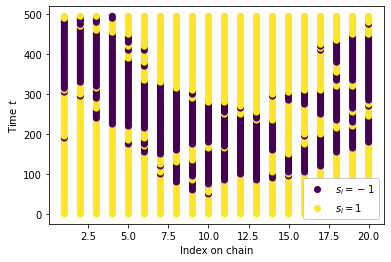

In [18]:

# ####################################### PART A ################################
# constants
kbT = 1
# 
J = 1
# Nr of spins
N = 20
# external field 
H = 0

# number of spin flips
L = 500





# initial spin configuration (all up)
spins = np.ones(N)


fig = plt.figure()


for l in range(L):
    # what spin flips?
    i = np.random.randint(0, N, 1)
    #energy difference
    DE = dE(spins, i, kbT)
    #does spin flip?
    if DE <= 0:
        spins[i] *= -1
    elif np.random.rand() < np.exp(-DE/kbT):
        spins[i] *= -1
    # plotting
    if l % 5 == 0:
        scat = plt.scatter(x=np.arange(1, N+1), y=np.zeros(N)+l, vmin=0, vmax=2, c=spins+1)
        


lab = [r"$s_i=-1$", r"$s_i=1$"]
hand = scat.legend_elements()[0]
legend1=plt.legend(handles=hand, labels=lab, framealpha=1, loc="lower right")
plt.xlabel("Index on chain")
plt.ylabel(r"Time $t$")


plt.savefig("1_1d_ising_evolution.pdf", dpi=200)



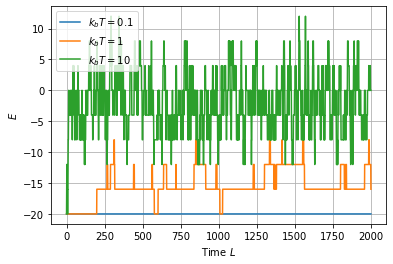

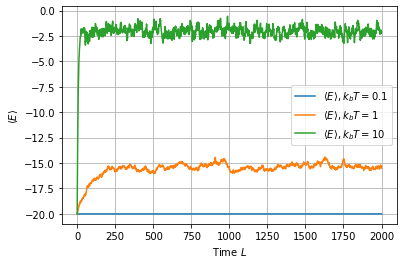

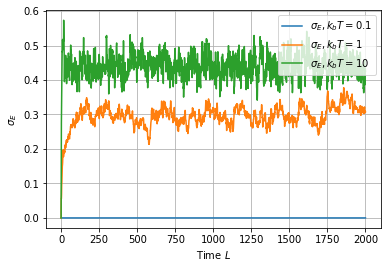

In [5]:

# ########################### PART B ################################

L = 2000

t = np.array([0.1, 1, 10])
time = np.arange(0, L+1, 1)

fig1 = plt.figure()
for i in range(3):
    plt.plot(time, run(N, L, t[i], 1)[0], label=r"$k_b T = %g$" % t[i])
plt.legend()
plt.grid()
plt.xlabel(r"Time $L$")
plt.ylabel(r"$E$")

plt.savefig("energyGoBOING.pdf", dpi=200)

# number of iterations
M = 100

meanE = np.array([np.zeros(L+1) for i in range(3)])
meanE2 = np.array([np.zeros(L+1) for i in range(3)])

var = np.array([np.zeros(L+1) for i in range(3)])

for i in range(3):
    kbT = t[i]
    for m in range(M):
        energy = run(N, L, kbT, 1)[0]
        meanE[i] += energy
        meanE2[i] += energy ** 2

    meanE[i] /= M
    meanE2[i] /= M
    
    var[i] = np.sqrt((meanE2[i] - meanE[i]**2)/M)

fig2 = plt.figure()

for i in range(3):
    plt.plot(time, meanE[i], label=r"$\langle E\rangle, k_b T = %g$" % t[i])
plt.legend()
plt.grid()
plt.xlabel(r"Time $L$")
plt.ylabel(r"$\langle E\rangle$")
plt.savefig("mean_energy.pdf", dpi=200)

fig3 = plt.figure()

for i in range(3):
    plt.plot(time, var[i], label=r"$\sigma_E, k_b T = %g$" % t[i])
plt.legend()
plt.grid()
plt.xlabel(r"Time $L$")
plt.ylabel(r"$\sigma_E$")
plt.savefig("variance.pdf", dpi=200)



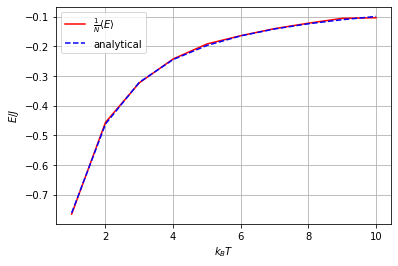

In [15]:

# ############################## PART C #########################
tburn = 1000


T = np.arange(1, 11)
Energy = np.zeros(len(T))
L = 1000

for t in range(len(T)):
    for m in range(M):
        Energy[t] += np.mean(run(L=L+tburn, t=T[t])[0][tburn:])
    Energy[t] /= N*M

fig4 = plt.figure()
plt.plot(T, Energy, "r", label=r"$\frac{1}{N}\langle E\rangle$")
plt.plot(T, analytical(T), "--b", label="analytical")
plt.legend()
plt.grid()
plt.xlabel(r"$k_B T$")
plt.ylabel(r"$E/J$")
plt.savefig("energy_per_spin.pdf", dpi=200)




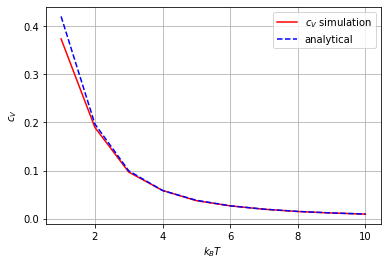

In [16]:


# ########################## PART D #########################


#Numbers of iteration
M = 100
# Temperature range
T = np.arange(1, 11)


# for plotting
# Energy = np.ones(len(T))
# meanE = np.ones(len(T))
varE = np.ones(len(T))

for t in range(len(T)):
    for m in range(M):
        r = run(L=L+tburn, t=T[t])
        #Energy[t] += np.mean(r[0][tburn:])
        varE[t] += np.var(r[0][tburn:])
    varE[t] /= M * N * T[t]**2



fig5 = plt.figure()
plt.plot(T, varE, "r", label=r"$c_V$ simulation")
plt.plot(T, heat_cap(T), "--b", label="analytical")
plt.legend()
plt.grid()
plt.xlabel(r"$k_B T$")
plt.ylabel(r"$c_V$")
plt.savefig("heat_cap.pdf", dpi=200)



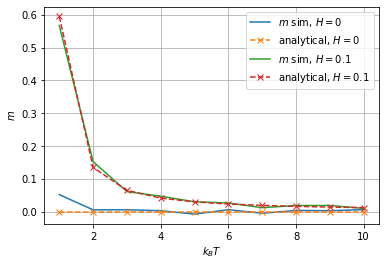

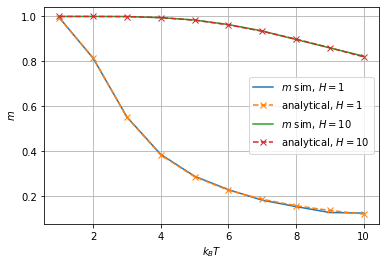

In [17]:

# ############################ PART E ############################


h = [0, 0.1, 1, 10]

magnetisation = np.array([np.zeros(len(T)) for i in range(len(h))])

for i in range(len(h)):
    for t in range(len(T)):
        for m in range(M):
            r = run(L=L+tburn, t=T[t], H=h[i])[1]
            magnetisation[i, t] += np.mean(r[tburn:])
        magnetisation[i, t] /= M * N


fig6 = plt.figure()
for i in range(0, len(h)//2):
    plt.plot(T, magnetisation[i, :], "-", label=r"$m$ sim, $H=%g$" % h[i])
    plt.plot(T, analytical_m(T, H=h[i]), "--x", label=r"analytical, $H=%g$" % h[i])
plt.legend()
plt.grid()
plt.xlabel(r"$k_B T$")
plt.ylabel(r"$m$")
plt.savefig("magnet_low.pdf", dpi=200)


fig7 = plt.figure()
for i in range(2, len(h)):
    plt.plot(T, magnetisation[i, :], "-", label=r"$m$ sim, $H=%g$" % h[i])
    plt.plot(T, analytical_m(T, H=h[i]), "--x", label=r"analytical, $H=%g$" % h[i])
plt.legend()
plt.grid()
plt.xlabel(r"$k_B T$")
plt.ylabel(r"$m$")
plt.savefig("magnet.pdf", dpi=200)
